# Experiments

## Load data

In [1]:
import logging
import tensorflow as tf

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

%config Completer.use_jedi = False # make autocompletion works in jupyter

tf.__version__

'2.4.1'

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv('../data/train.csv.zip')
args.raw_test = pd.read_csv('../data/test.csv.zip')
args.predictions_folder = Path('../predictions')
args.n_splits = 5
args.n_jobs = 3
args.seed = 101
args.val_fraction=0.1

args.train = args.raw_train.iloc[:, 1:].copy()
args.labels = args.raw_train['label'].copy()
args.test = args.raw_test.copy()


args.predictions_folder.mkdir(parents=True, exist_ok=True) 

In [3]:
args.raw_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
args.raw_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# OO-style image rendering
def draw_digit(pixels_2d, label=None, size_inches=None):
    fig, ax = plt.subplots()
    if label is not None:
        ax.set_title(label)
    if size_inches:
        fig.set_size_inches(size_inches[0], size_inches[1])
    imgplot = ax.imshow(pixels_2d)

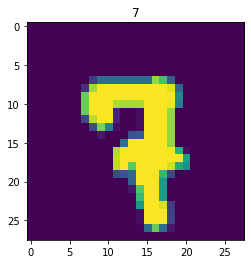

In [6]:
# Matlbab state-based style of image rendering 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1) 
title = args.raw_train.iloc[random_row, 0]
plt.title(title)
imgplot = plt.imshow(args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28))

In [7]:
import sklearn.utils.multiclass

X = args.train.to_numpy().reshape(args.train.shape[0], 28, 28, 1)
y = pd.get_dummies(args.labels, prefix='label').to_numpy()
y_sparse = args.labels.to_numpy()
X_test = args.test.to_numpy().reshape(args.test.shape[0], 28, 28, 1)

log.info('X.shape: %s', repr(X.shape))
log.info('X[0][14][14]: %s', X[0][14][14])

log.info('y.shape: %s', repr(y.shape))
log.info('y[0], %s', y[0])
log.info('type of target y: %s', repr(sklearn.utils.multiclass.type_of_target(y)))

log.info('y_sparse.shape: %s', repr(y_sparse.shape))
log.info('y_sparse: %s', repr(y_sparse))
log.info('y_sparse[0]: %s', y_sparse[0])
log.info('type of target y_sparse: %s', repr(sklearn.utils.multiclass.type_of_target(y_sparse)))

def csv_sparse_predictions(predictions_sparse, filename):
    image_ids = np.arange(1, len(predictions_sparse) + 1)
    submission = pd.DataFrame({'ImageId': image_ids, 'Label': predictions_sparse})
    filepath = args.predictions_folder/filename
    
    submission.to_csv(filepath, index=False)
    log.info('Saved file: %s', filepath)

2021-02-01 10:44:42,195 : INFO : X.shape: (42000, 28, 28, 1)
2021-02-01 10:44:42,195 : INFO : X[0][14][14]: [254]
2021-02-01 10:44:42,196 : INFO : y.shape: (42000, 10)
2021-02-01 10:44:42,197 : INFO : y[0], [0 1 0 0 0 0 0 0 0 0]
2021-02-01 10:44:42,204 : INFO : type of target y: 'multilabel-indicator'
2021-02-01 10:44:42,205 : INFO : y_sparse.shape: (42000,)
2021-02-01 10:44:42,206 : INFO : y_sparse: array([1, 0, 1, ..., 7, 6, 9])
2021-02-01 10:44:42,210 : INFO : y_sparse[0]: 1
2021-02-01 10:44:42,213 : INFO : type of target y_sparse: 'multiclass'


## Experiments
### Multioutput classification

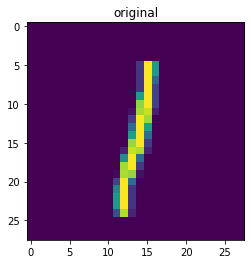

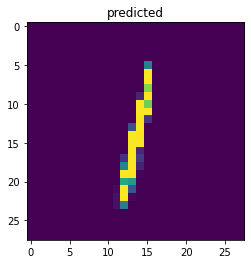

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

Y_train, Y_val, _, _ = train_test_split(X, y_sparse, test_size=0.25, random_state=42)
Y_train = Y_train.reshape(len(Y_train), 28*28)
Y_val = Y_val.reshape(len(Y_val), 28*28)
draw_digit(Y_val[1].reshape(28, 28), label="original")


noise_X_train = np.random.randint(255, size=(len(Y_train), 28*28))
X_train = Y_train + noise_X_train
noise_X_val = np.random.randint(255, size=(len(Y_val), 28*28))
X_val = Y_val + noise_X_val

knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
cleared = knn.predict([X_val[1]])
draw_digit(cleared.reshape(28, 28), label="predicted")

### Confusion matrix

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X_train, X_val, y_train, y_val = train_test_split(X, y_sparse, test_size=0.95, random_state=args.seed)
X_train = X_train.reshape(len(X_train), 28*28)
X_val = X_val[:100].reshape(len(X_val[:100]), 28*28)
y_val = y_val[:100]
svc = SVC()
svc.fit(X_train, y_train)
svc.predict(X_val)

confusion_matrix(y_val, svc.predict(X_val))

array([[11,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 16,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 11,  0,  0,  1,  1,  0,  1,  0],
       [ 0,  0,  0,  8,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  7,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 13,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  9,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0, 11]])

### Basics
### Sequential API baseline

2021-02-01 14:43:43,285 : INFO : None
2021-02-01 14:43:43,289 : INFO : (300, 100)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1182/1182 [==============================] - 5s 3ms/step - loss: 6.1065 - sparse_categorical_accuracy: 0.8093 - val_loss: 0.5981 - val_sparse_categorical_accuracy: 0.8805
Epoch 2/50
1182/1182 [==============================] - 4s 3ms/s

1182/1182 [==============================] - 3s 3ms/step - loss: 0.0424 - sparse_categorical_accuracy: 0.9918 - val_loss: 0.3995 - val_sparse_categorical_accuracy: 0.9679
Epoch 41/50
1182/1182 [==============================] - 3s 3ms/step - loss: 0.0495 - sparse_categorical_accuracy: 0.9906 - val_loss: 0.3842 - val_sparse_categorical_accuracy: 0.9681
Epoch 42/50
1182/1182 [==============================] - 3s 3ms/step - loss: 0.0511 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.5150 - val_sparse_categorical_accuracy: 0.9681
Epoch 43/50
1182/1182 [==============================] - 3s 3ms/step - loss: 0.0549 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.4797 - val_sparse_categorical_accuracy: 0.9690
Epoch 44/50
1182/1182 [==============================] - 3s 3ms/step - loss: 0.0417 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.4360 - val_sparse_categorical_accuracy: 0.9693
Epoch 45/50
1182/1182 [==============================] - 3s 3ms/step - loss: 0.0529 - sparse_cate

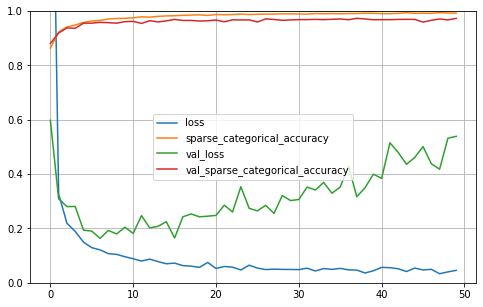

2021-02-01 14:46:39,999 : INFO : Saved file: ../predictions/experiments-baseline.csv


In [16]:
import keras
from keras import layers 

def seq_baseline():
    def build():
        model = keras.models.Sequential()
        model.add(keras.layers.Flatten(input_shape=[28, 28]))
        model.add(keras.layers.Dense(300, activation='elu'))
        model.add(keras.layers.Dense(100, activation='elu'))
        model.add(keras.layers.Dense(10, activation='softmax'))

        log.info(model.summary())
        log.info(model.layers[2].get_weights()[0].shape)

        model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=keras.optimizers.Nadam(),
                     metrics=[keras.metrics.sparse_categorical_accuracy])
        return model
    
    def plot(history):
        pd.DataFrame(history.history).plot(figsize=(8, 5))
        plt.grid(True)
        plt.ylim(0, 1)
        plt.show()
    
   
    model = build()
    history = model.fit(X, y_sparse, epochs=50, validation_split=args.val_fraction)
    plot(history)
    predictions = np.argmax(model.predict(X_test), axis=-1)
    csv_sparse_predictions(predictions, 'experiments-baseline.csv')
    
    
seq_baseline()

#### Baseline result
| Approach | Model  | Test score  | CV mean score |
|---|---|---|---|
| Baseline | 50 epochs | 0.96660 | 0.9738 |


### Functional API. Arbitrary network

2021-02-01 15:11:01,753 : INFO : None


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 784)          0           input_19[0][0]                   
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 300)          235500      flatten_8[0][0]                  
____________________________________________________________________________________________

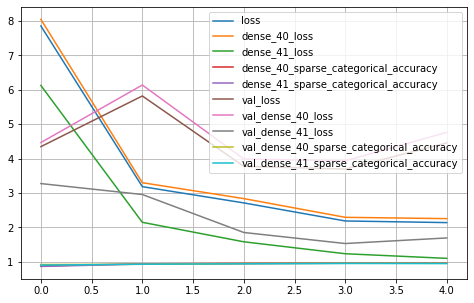

In [29]:
def functional_api_arbitrary():
    i1 = keras.layers.Input(shape=X.shape[1:])
    f1 = keras.layers.Flatten(input_shape=[28, 28])(i1)
    h1 = keras.layers.Dense(300, activation='elu')(f1)
    h2 = keras.layers.Dense(100, activation='elu')(h1)
    i2 = keras.layers.Input(shape=X.shape[1:])
    f2 = keras.layers.Flatten(input_shape=[28, 28])(i2)
    c = keras.layers.Concatenate()([f2, h2])
    o1 = keras.layers.Dense(10, activation='softmax')(c)
    o2 = keras.layers.Dense(10, activation='softmax')(h2)
    model = keras.Model(inputs=[i1, i2], outputs=[o1, o2])

    model.compile(loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
                  loss_weights=[0.9, 0.1],
                 optimizer=keras.optimizers.Nadam(),
                 metrics=[keras.metrics.sparse_categorical_accuracy])
    log.info(model.summary())
    history = model.fit([X, X], [y_sparse, y_sparse], epochs=5, validation_split=args.val_fraction)
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()